In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/CPT_II_ConnersContinuousPerformanceTest.csv'
df = pd.read_csv(file_path, delimiter=';')
df.head()


Mounted at /content/drive


,ID,Assessment Status,Assessment Duration,Type,LastTrial,Trial1,Response1,Trial2,Response2,Trial3,...,Raw Score HitRTIsi,Percent HitRTIsi,General TScore HitSEIsi,Adhd TScore HitSEIsi,Neuro TScore HitSEIsi,Raw Score HitSEIsi,Percent HitSEIsi,Adhd Confidence Index,Neuro Confidence Index,Old Overall Index
0,2,3,839999,6,360,11,-1,13,469,7,...,0.049592,0,48.021103,47.772537,43.224297,-0.021096,0,61.145496,58.749630,10.070000
1,3,3,839999,6,360,12,-1,0,371,2,...,0.064090,0,42.234097,38.263283,41.574574,-0.077351,0,86.871597,61.088688,4.440000
2,4,3,839999,6,360,14,-1,10,-1,3,...,0.077233,0,45.680782,42.289310,43.868061,-0.046142,0,99.900002,86.131813,18.340000
3,5,3,839999,6,360,12,459,7,289,12,...,0.085540,0,85.698700,70.469986,80.228539,0.410634,0,99.900002,99.900002,8.950001
4,7,3,839998,6,360,11,841,7,-1,5,...,0.024632,0,42.058998,43.349667,39.992119,-0.071200,0,32.291084,24.225414,0.000000


In [5]:
df.isna().sum()

,0
ID,0
Assessment Status,0
Assessment Duration,0
Type,0
LastTrial,0
...,...
Raw Score HitSEIsi,0
Percent HitSEIsi,0
Adhd Confidence Index,0
Neuro Confidence Index,0


In [6]:
df.isna().sum().sum()

np.int64(0)

In [8]:
# Define target variable (ADHD Confidence Index as binary classification)

df['ADHD_Diagnosis'] = (df['Adhd Confidence Index'] > 50).astype(int)

# 1 = ADHD, 0 = No ADHD


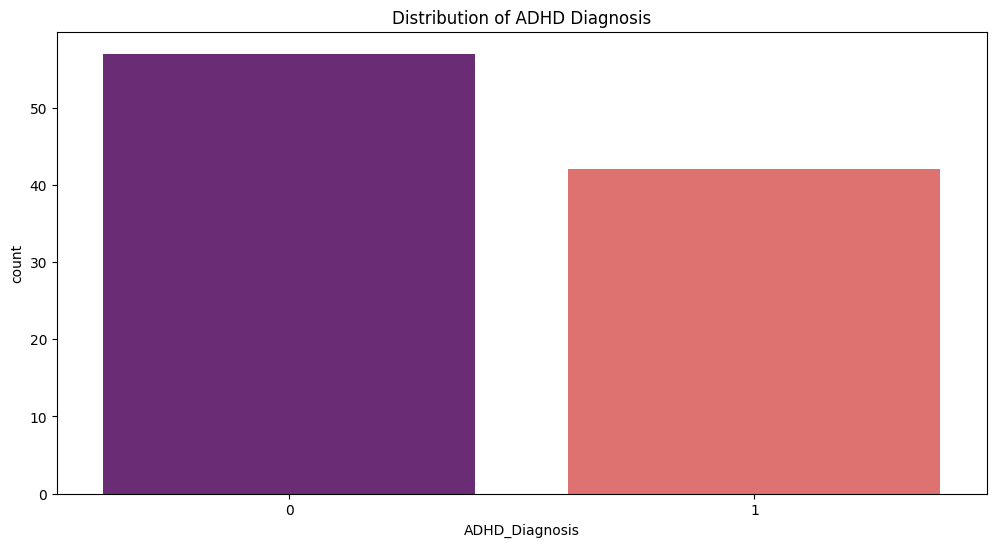

In [15]:
# Exploratory Data Analysis
plt.figure(figsize=(12,6))
sns.countplot(x='ADHD_Diagnosis', data=df, palette='magma')
plt.title('Distribution of ADHD Diagnosis')
plt.show()


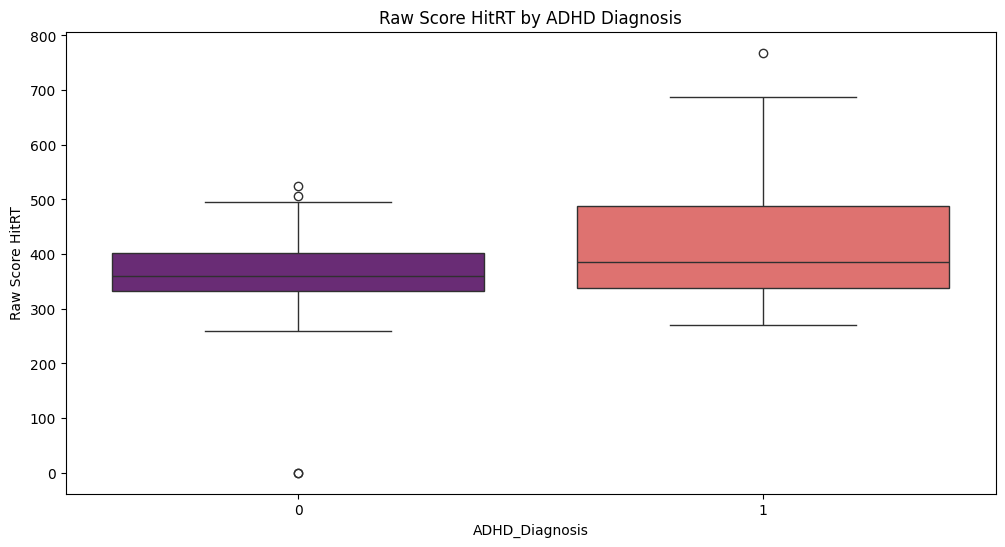

In [19]:
plt.figure(figsize=(12,6))
sns.boxplot(x='ADHD_Diagnosis', y=df['Raw Score HitRT'], data=df, palette='magma')
plt.title('Raw Score HitRT by ADHD Diagnosis')
plt.show()


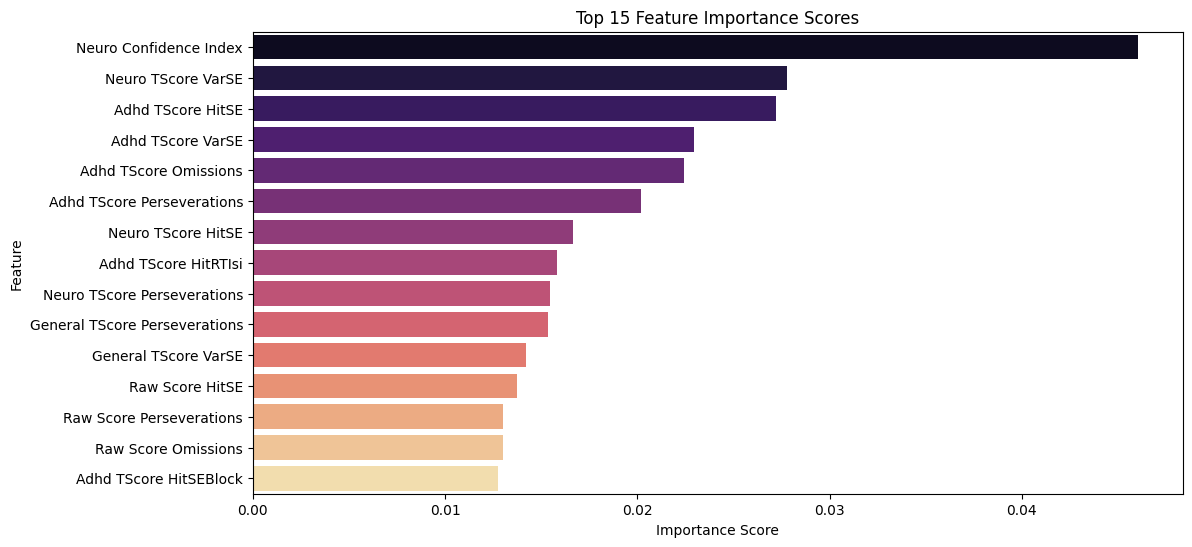

In [21]:
# Drop non-relevant columns (ID and categorical variables if any)
features_to_drop = ['ID', 'ADHD_Diagnosis', 'Adhd Confidence Index']
X = df.drop(columns=features_to_drop, errors='ignore')
y = df['ADHD_Diagnosis']

# Feature Selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(15)
selected_features = feature_importances['Feature'].tolist()

# Keep only the top 15 most important features
X = X[selected_features]

# Plot Feature Importance
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette='magma')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importance Scores")
plt.show()

In [22]:
selected_features

['Neuro Confidence Index',
 'Neuro TScore VarSE',
 'Adhd TScore HitSE',
 'Adhd TScore VarSE',
 'Adhd TScore Omissions',
 'Adhd TScore Perseverations',
 'Neuro TScore HitSE',
 'Adhd TScore HitRTIsi',
 'Neuro TScore Perseverations',
 'General TScore Perseverations',
 'General TScore VarSE',
 'Raw Score HitSE',
 'Raw Score Perseverations',
 'Raw Score Omissions',
 'Adhd TScore HitSEBlock']

In [24]:
df_combined = pd.concat([X, y], axis=1)
df_combined.head()

,Neuro Confidence Index,Neuro TScore VarSE,Adhd TScore HitSE,Adhd TScore VarSE,Adhd TScore Omissions,Adhd TScore Perseverations,Neuro TScore HitSE,Adhd TScore HitRTIsi,Neuro TScore Perseverations,General TScore Perseverations,General TScore VarSE,Raw Score HitSE,Raw Score Perseverations,Raw Score Omissions,Adhd TScore HitSEBlock,ADHD_Diagnosis
0,58.749630,47.313202,52.266724,56.680264,48.617069,45.960991,46.328171,44.764221,44.977715,45.910095,63.262173,7.099574,0,5,73.413300,1
1,61.088688,44.698776,49.884254,52.487644,70.258568,77.101982,43.217041,53.880283,49.628159,151.525207,55.966831,5.512853,5,11,56.108963,1
2,86.131813,44.092140,73.548889,51.577404,81.135651,64.040787,50.403320,57.213779,48.388687,109.223038,54.914539,8.852735,3,15,53.179558,1
3,99.900002,71.502686,57.789284,67.443703,50.876575,60.982868,56.714081,51.601707,64.221878,95.529411,83.324196,11.575007,8,10,72.043434,1
4,24.225414,39.814167,43.678928,42.459812,45.635860,45.960991,40.733135,38.070797,44.977715,45.910095,47.997269,5.002260,0,1,49.865376,0


In [25]:
df=df_combined.copy()

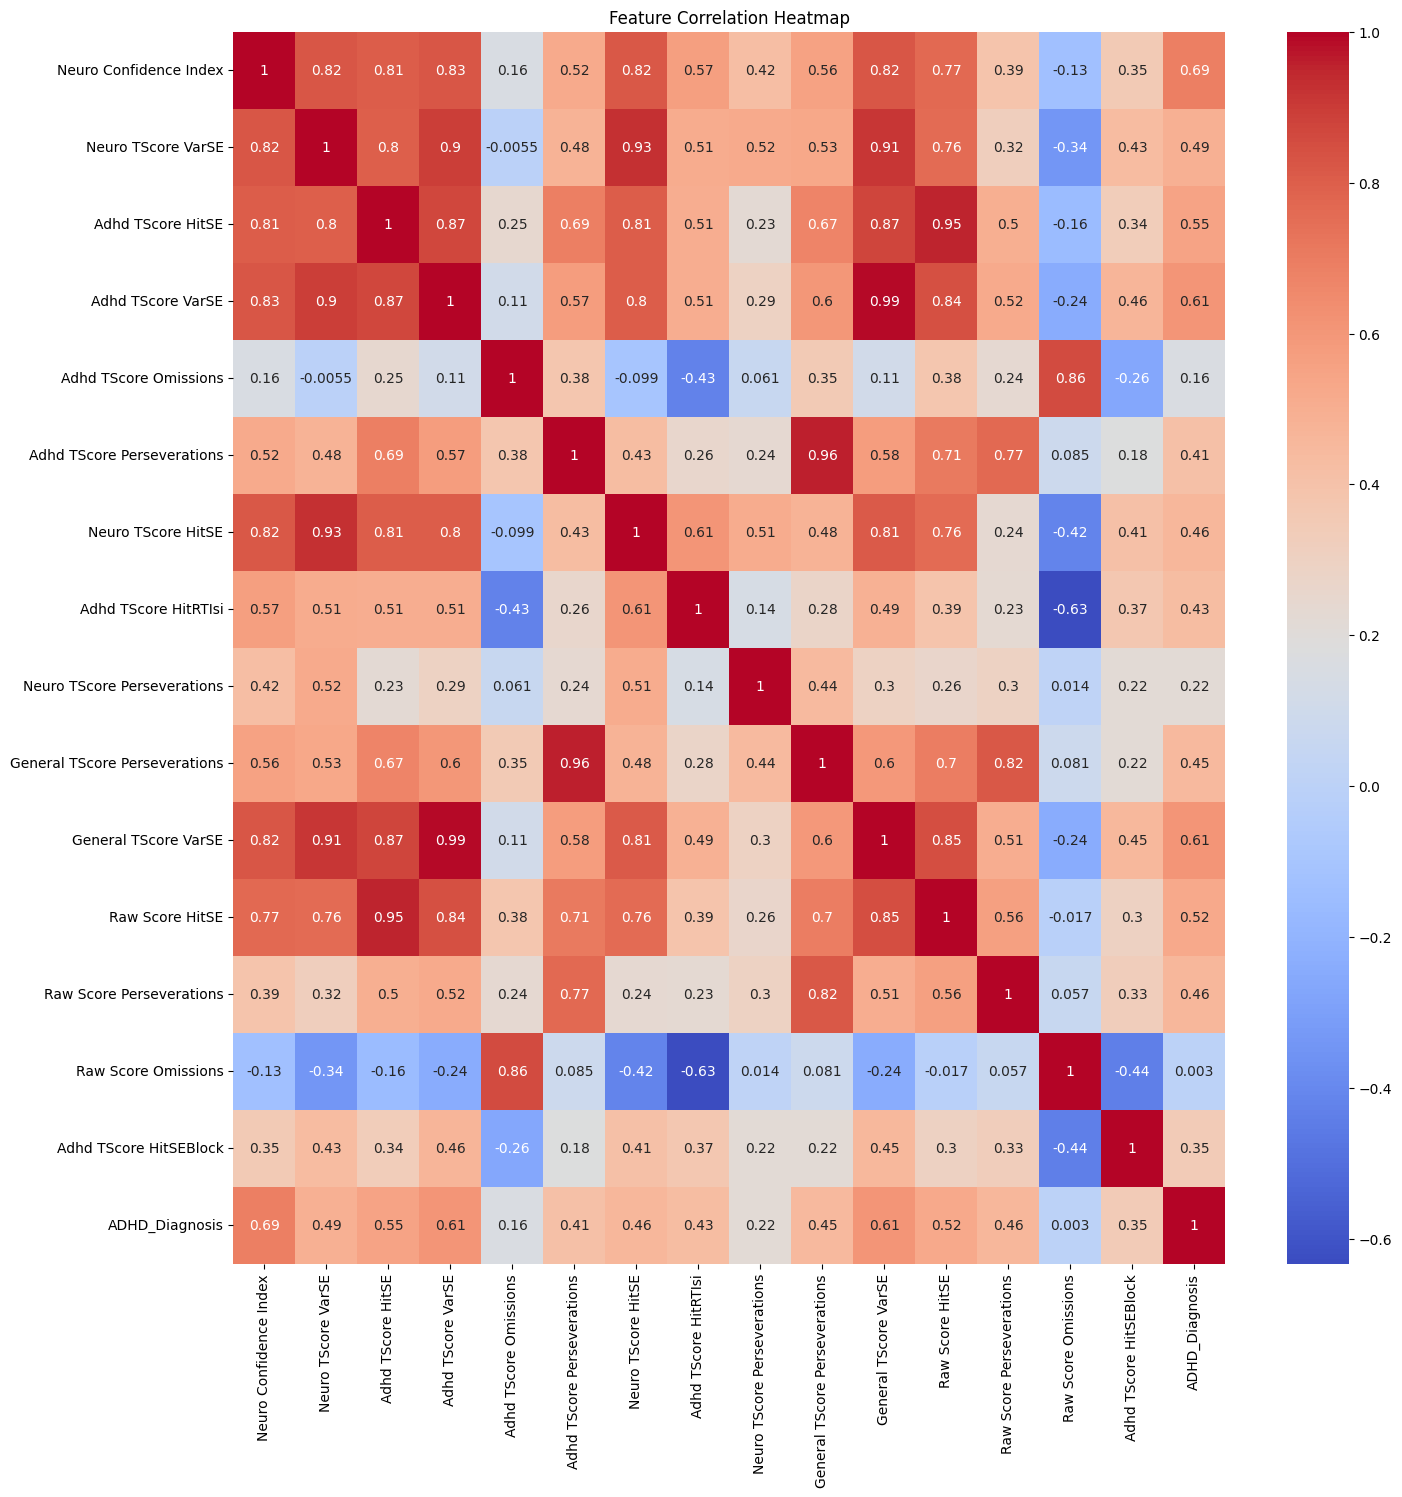

In [28]:
# Feature Correlation Heatmap
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

In [29]:
# Drop non-relevant columns (ID and categorical variables if any)
features_to_drop = ['ID', 'Adhd Confidence Index', 'ADHD_Diagnosis']
X = df.drop(columns=features_to_drop, errors='ignore')
y = df['ADHD_Diagnosis']


# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


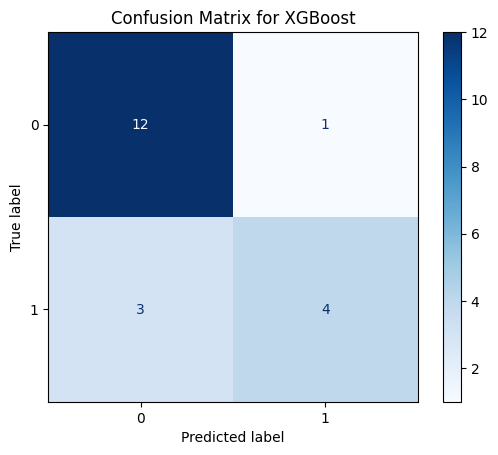


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.80      0.57      0.67         7

    accuracy                           0.80        20
   macro avg       0.80      0.75      0.76        20
weighted avg       0.80      0.80      0.79        20

[LightGBM] [Info] Number of positive: 35, number of negative: 44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443038 -> initscore=-0.228842
[LightGBM] [Info] Start training from score -0.228842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

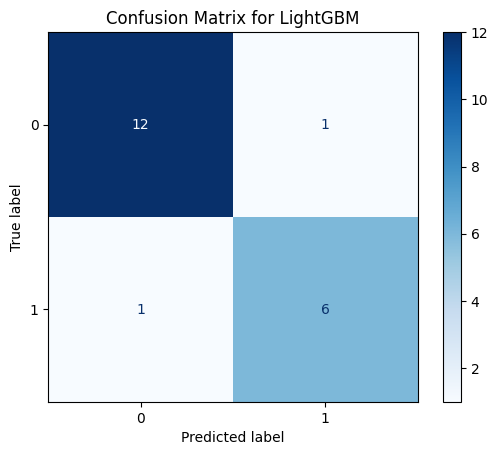


Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.86      0.86      0.86         7

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



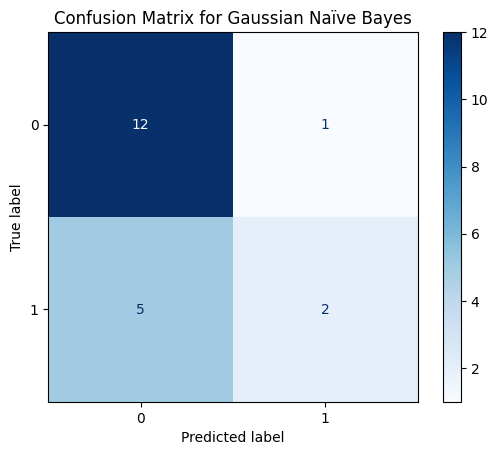


Classification Report for Gaussian Naïve Bayes:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.67      0.29      0.40         7

    accuracy                           0.70        20
   macro avg       0.69      0.60      0.60        20
weighted avg       0.69      0.70      0.66        20

                  Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0               XGBoost       0.8   0.800000  0.571429  0.666667  0.923077
1              LightGBM       0.9   0.857143  0.857143  0.857143  0.901099
2  Gaussian Naïve Bayes       0.7   0.666667  0.285714  0.400000  0.807692


In [30]:
# Initialize models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "Gaussian Naïve Bayes": GaussianNB()
}

# Train and evaluate models
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)